Strategy to **mitigate with the imbalance** with the dataset (34,932 non-fire(marked as 0) - 133 fire(marked as 1-2-3)) in the training dataset:
- In order to have 133 fire records in both training and evaluating, we seperate the whole data into **majority (0) and minority(1-2-3)**. And there is a need to cut down on the majority. After trying with different hypeparameter, we saw that using a random 70% of the majority, and for the minority: 105 to train and 27 to evaluate.

- The 70/30 training/evaluating yields the best result.

- Also we add the **weight** per classes

- We use early stopping, and we use **Macro-F1 for class 1-2-3** (minority) instead of normal F1 or Accuracy to mainly focus on the minority class

- Compared with different model using Macro for 1-2-3:
    - RandomForrest: 0.29
    - XGBClassifier: 0.35
    - Initial Neural Network: ~0.31
    - Our optimized: 0.6473

In [246]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# 1. Load data
df = pd.read_csv("C:\\Users\\taduc\\Downloads\\SAP-CONUHACKS-IX\\Data\\Preprocessed_2\\training_df.csv")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

X = df.drop(columns=["severity"]).values
y = df["severity"].values

# Separate minority (classes 1,2,3) and majority (class 0) indices
minority_indices = np.where(np.isin(y, [1, 2, 3]))[0]
majority_indices = np.where(y == 0)[0]


# Shuffle minority indices and split: 110 for training and 23 for evaluation
shuffled_minority = np.copy(minority_indices)
np.random.shuffle(shuffled_minority)
min_train = shuffled_minority[:105]
min_val = shuffled_minority[105:133]  # 27 samples

# For majority indices, perform an 70/30 split
majority_train, majority_val = train_test_split(majority_indices, test_size=0.3, random_state=42)

# Drop 30% of the majority class in training by randomly sampling 70% of them
np.random.seed(42)
num_majority_train = len(majority_train)
sample_size = int(0.7 * num_majority_train)
majority_train_under = np.random.choice(majority_train, size=sample_size, replace=False)

# Combine indices from both groups
train_indices = np.concatenate([majority_train_under, min_train])
val_indices = np.concatenate([majority_val, min_val])

# Create training and evaluation sets
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

# # Balance the training set using RandomUnderSampler and SMOTE
# # Set the target count for majority class (0) equal to the maximum count among the minority classes
# counter = collections.Counter(y_train)
# if 0 in counter:
#     target_majority = max([counter[c] for c in counter if c != 0])
# else:
#     target_majority = 0

# under_sampler = RandomUnderSampler(sampling_strategy={0: target_majority}, random_state=42)
# smote = SMOTE(sampling_strategy='not majority', random_state=42)
# pipeline = Pipeline(steps=[('under', under_sampler), ('smote', smote)])

# X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

In [248]:
# 2. Weighted sampler
class_counts = np.bincount(y_train_t)
weights_per_class = 1.0 / class_counts
sample_weights = [weights_per_class[label] for label in y_train_t]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_ds, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=64)

In [249]:
# 3. Model
model = nn.Sequential(
    # First neural network block
    nn.Sequential(
        nn.Linear(X_train.shape[1], 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
    ),
    # Second neural network block
    nn.Sequential(
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256)
    ),
    # Final fully connected layer
    nn.Linear(256, 4)
)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-8)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 4. Add this helper function before the training loop
def custom_severity_metric(targets, preds):
    # F1 for severity classes 1,2,3
    mask = targets > 0
    if mask.any():
        f1_123 = f1_score(targets[mask], preds[mask], average='macro', labels=[1,2,3])
    else:
        f1_123 = 0.0
    
    # False positive penalty for class 0
    zero_mask = targets == 0
    if zero_mask.any():
        fp_rate = ((preds[zero_mask] > 0).sum() / zero_mask.sum())
    else:
        fp_rate = 0.0
        
    # Combined metric
    return  f1_123 - 0.0 * fp_rate

# Update training loop
best_combined_score = float('-inf')
best_f1_123 = float('-inf')
patience = 100
wait = 0
best_model_fixed_path = "C:\\Users\\taduc\\Downloads\\SAP-CONUHACKS-IX\\BackEnd\\Part_2\\models\\best_model.pt"

for epoch in range(1000):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for val_x, val_y in val_loader:
            out = model(val_x)
            val_preds.append(out.argmax(dim=1).cpu().numpy())
            val_targets.append(val_y.cpu().numpy())

    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)

    # Calculate combined metric
    combined_score = custom_severity_metric(val_targets, val_preds)

    print(f"Epoch {epoch+1}, Combined Score: {combined_score:.4f}")

    # Early stopping using combined score
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

Epoch 1, Combined Score: 0.2591
Epoch 2, Combined Score: 0.3580
Epoch 3, Combined Score: 0.1778
Epoch 4, Combined Score: 0.3259
Epoch 5, Combined Score: 0.2486
Epoch 6, Combined Score: 0.3175
Epoch 7, Combined Score: 0.2878
Epoch 8, Combined Score: 0.3468
Epoch 9, Combined Score: 0.3159
Epoch 10, Combined Score: 0.3159
Epoch 11, Combined Score: 0.2900
Epoch 12, Combined Score: 0.3156
Epoch 13, Combined Score: 0.3500
Epoch 14, Combined Score: 0.3572
Epoch 15, Combined Score: 0.4247
Epoch 16, Combined Score: 0.3558
Epoch 17, Combined Score: 0.4277
Epoch 18, Combined Score: 0.3894
Epoch 19, Combined Score: 0.4254
Epoch 20, Combined Score: 0.4184
Epoch 21, Combined Score: 0.4254
Epoch 22, Combined Score: 0.4277
Epoch 23, Combined Score: 0.4558
Epoch 24, Combined Score: 0.3825
Epoch 25, Combined Score: 0.3825
Epoch 26, Combined Score: 0.4254
Epoch 27, Combined Score: 0.4990
Epoch 28, Combined Score: 0.4587
Epoch 29, Combined Score: 0.4264
Epoch 30, Combined Score: 0.3926
Epoch 31, Combined 

In [251]:
# 5. Load best model and save
model.load_state_dict(best_model_state)
save_path = f"C:\\Users\\taduc\\Downloads\\SAP-CONUHACKS-IX\\BackEnd\\Part_2\\models\\model_{best_combined_score:.4f}.pt"
torch.save(model, save_path)

Confusion Matrix (rows=actual, cols=pred):
[[10361    23    25    71]
 [    0     6     4     3]
 [    0     5     2     1]
 [    0     3     1     3]]


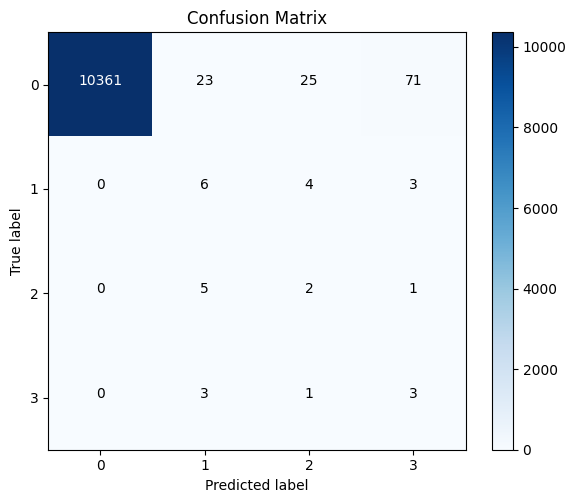

In [252]:
# 6. Confusion matrix for best model
model.eval()
val_preds = []
val_targets = []
with torch.no_grad():
    for val_x, val_y in val_loader:
        out = model(val_x)
        val_preds.append(out.argmax(dim=1).cpu().numpy())
        val_targets.append(val_y.cpu().numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

cm = confusion_matrix(val_targets, val_preds, labels=[0,1,2,3])
print("Confusion Matrix (rows=actual, cols=pred):")
print(cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, [0,1,2,3])
plt.yticks(tick_marks, [0,1,2,3])
plt.xlabel("Predicted label")
plt.ylabel("True label")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

In [253]:
# Use the model to predict on the test set and save the predictions that diffenrent from 0 on a json file
df_test = pd.read_csv("C:\\Users\\taduc\\Downloads\\SAP-CONUHACKS-IX\\Data\\Preprocessed_2\\testing_df.csv")
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].astype('category').cat.codes

X_test = df_test.values
X_test_t = torch.tensor(X_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    test_preds = model(X_test_t).argmax(dim=1).cpu().numpy()

# Count the number of predictions that are not 0
non_zero_preds = np.count_nonzero(test_preds)
print(f"Number of non-zero predictions: {non_zero_preds}")

# Save all columns the predictions to a json file
df_test["severity"] = test_preds
df_test.to_json("C:\\Users\\taduc\\Downloads\\SAP-CONUHACKS-IX\\BackEnd\\Part_2\\predictions.json", orient='records')
print("Predictions saved to predictions.json")

Number of non-zero predictions: 351
Predictions saved to predictions.json
